### Minimal code to generate data from Ising model
1/2/24 Noah Chavez

In [47]:
# Imports -- no Pygame needed 
import numpy as np
import random
import matplotlib.pyplot as plt
 
# init lattice
def initLattice(latticeSize: int, siteSize: int) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    for x in np.arange(0, latticeSize*siteSize, siteSize):
        for y in np.arange(0, latticeSize*siteSize, siteSize):
            spin = random.randint(0,1)
            if(spin == 1):
                lattice[int(x/siteSize)][int(y/siteSize)] = 1
            else:
                lattice[int(x/siteSize)][int(y/siteSize)] = -1
    return lattice


# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff


size = 25 #was 50
siteSize = 10
lat = initLattice(size,siteSize) #lattice starts at high T (randomized)

# Simulation loop
T = 0.01 #initial temperature to start metropolis on
iters = 40000

#store m in array
mArr = np.array([])

for i in range(iters):
    #in units of J/k (J is epsilon the coupling constant, k is boltzmann k) Tc=2.27
    #calculate magnetization (should this go in just the while True loop?)
    m = 0
    for x in range(size):
        for y in range(size):
            m += lat[x][y]

    #print("m: %s" % m)
    #add m to array
    mArr = np.append(mArr,m)
   
    #calc Ediff for a site
    i = random.randint(0,size-1) 
    j = random.randint(0,size-1)
    Ediff = deltaU(i,j,lat)
    #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
    if(Ediff <= 0):
        lat[i][j] = -lat[i][j] 
    else:
        #now only flip site according to Boltzmann factor
        boltzmannRandom = random.uniform(0,1)
        if(boltzmannRandom < np.exp(-Ediff/T)):
            lat[i][j] = -lat[i][j]


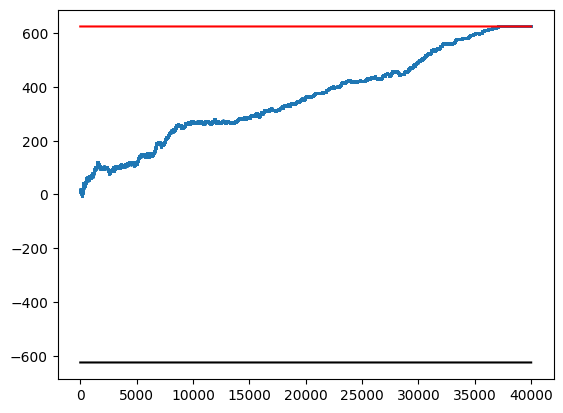

In [48]:
#Now plot the magnitzation as a func of iteration
eqMPos = np.full((mArr.size,1),np.power(size,2))
eqMNeg = np.full((mArr.size,1),-np.power(size,2))
iter = np.arange(0,mArr.size)
plt.plot(iter,eqMPos, color="red")
plt.plot(iter,eqMNeg, color="black")
plt.scatter(iter, mArr, s=1)
plt.show()

I wonder if finite scaling effects produce metastable states with higher frequency? **It seems that ~40,000 iterations is enough for the system to reach equilibrium** Therefore, a first implementation to keep the system in equilibrium as we change temp is to step temp up, wait 40,000 steps and then step up. 40,000 iterations takes 3.3 seconds.